# Arabic Visual Question Answering
# # COCO QA Dataset

In [1]:
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json

import numpy as np 
import os
from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

from keras.layers import Dense, Embedding, LSTM, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re 

from keras.layers import dot
from keras.layers import Add
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

In [2]:
import json
from pprint import pprint
from keras.layers import Embedding
from keras.layers import CuDNNLSTM
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D,MaxPooling2D, Activation, Dropout, BatchNormalization, Input,LeakyReLU,AveragePooling2D
from keras.layers import *
from keras.models import Model
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import Sequence
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
import glob
import json
import tensorflow as tf
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random
import tqdm

In [4]:
#Here we check is GPU is available for training or not Or whether the tensorflow version can utilize gpu 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

Number of GPUs : 0
Tensorflow GPU : True


In [5]:

def process_question_annotation_tr():
    """
    Creates a JSON file whose elements are (image_path, question, answer, answers)
    from the Questions and Annotations files.

    Input:
      subset: subset can be "train2014" or "val2014"

    Returns:
      None
    """
    anno = json.load(open('./mscoco_train2014_annotations.json', 'r'))
    ques = json.load(open('./OpenEnded_mscoco_train2014_questions.json', 'r'))
    imdir='%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    data = []

    for i in tqdm.tqdm(range(len(anno['annotations']))):
        image_path = imdir%('train2014', 'train2014', anno['annotations'][i]['image_id'])
        question = ques['questions'][i]['question']
        ans = anno['annotations'][i]['multiple_choice_answer']
        data.append({'img_path': image_path, 'question': question, 'ans': ans})

    json.dump(data, open('./vqa_raw_train2014.json', 'w'))

In [6]:
def process_question_annotation_v():
    """
    Creates a JSON file whose elements are (image_path, question, answer, answers)
    from the Questions and Annotations files.

    Input:
      subset: subset can be "train2014" or "val2014"

    Returns:
      None
    """
    anno = json.load(open('./mscoco_val2014_annotations.json', 'r'))
    ques = json.load(open('./OpenEnded_mscoco_val2014_questions.json', 'r'))
    imdir='%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    data = []
    
    for i in tqdm.tqdm(range(len(anno['annotations']))):
        image_path = imdir%('val2014', 'val2014', anno['annotations'][i]['image_id'])
        question = ques['questions'][i]['question']
        ans = anno['annotations'][i]['multiple_choice_answer']
        data.append({'img_path': image_path, 'question': question, 'ans': ans})

    json.dump(data, open('./vqa_raw_val2014.json', 'w'))

In [7]:
#process_question_annotation_tr()
process_question_annotation_v()

100%|██████████████████████████████████████████████████████████████████████| 121512/121512 [00:00<00:00, 305540.99it/s]


In [8]:
#train_data = json.load(open('./vqa_raw_train2014.json', 'r'))
val_data = json.load(open('./vqa_raw_val2014.json', 'r'))

In [9]:
#from operator import itemgetter
#ques = list(map(itemgetter('question'), train_data))
#ans = list(map(itemgetter('ans'), train_data))
#image_list = list(map(itemgetter('img_path'), train_data))

In [10]:
from operator import itemgetter
vques = list(map(itemgetter('question'), val_data))
vans = list(map(itemgetter('ans'), val_data))
vimage_list = list(map(itemgetter('img_path'), val_data))

In [11]:
import re

def process_sentence(sentence):
    """
    Cleans a given raw sentence

    Input:
        sentence: a raw sentence

    Returns:
        Returns the cleaned version of the sentence
    """
    # remove the character ".", except from floating numbers
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    # remove any "," between digits, eg: 5,6
    commaStrip   = re.compile("(\d)(\,)(\d)")
    # list of punctuations to remove
    punct        = [';', r"/", '[', ']', '"', '{', '}',
                    '(', ')', '=', '+', '\\', '_', '-',
                    '*', ':', '^', '%', '$', '#', '&',
                    '>', '<', '@', '`', ',', '?', '!']
    # contraction mappings
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                    "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                    "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                    "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                    "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                    "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                    "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                    "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                    "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                    "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                    "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                    "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                    "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                    "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "where's": "where is", "whereve": "where've", \
                    "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                    "youll": "you'll", "youre": "you're", "youve": "you've"}

    # replace new line with a white space
    inText = sentence.replace('\n', ' ')
    # replace multiple white space with single white space
    inText = inText.replace('\t', ' ')
    inText = inText.strip()
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) or \
           (re.search(commaStrip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
    outText = periodStrip.sub("", outText, re.UNICODE)
    outText = outText.lower().split()
    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [12]:
import pandas as pd

In [13]:
#questions_train_processed = pd.Series(ques).apply(process_sentence)

In [14]:
questions_val_processed = pd.Series(vques).apply(process_sentence)

In [15]:
#data={'Path':image_list,'Question':questions_train_processed,'Answer':ans}
#train_dataframe=pd.DataFrame.from_records(data)

In [16]:
#train_dataframe.head()

In [17]:
datav={'Path':vimage_list,'Question':questions_val_processed,'Answer':vans}
val_dataframe=pd.DataFrame.from_records(datav)

In [18]:
val_dataframe.head()

,Answer,Path,Question
0,wood,val2014/COCO_val2014_000000350623.jpg,what is the table made of
1,no,val2014/COCO_val2014_000000350623.jpg,is the food napping on the table
2,kettles,val2014/COCO_val2014_000000350623.jpg,what has been upcycled to make lights
3,no,val2014/COCO_val2014_000000008647.jpg,is this an spanish town
4,yes,val2014/COCO_val2014_000000008647.jpg,are there shadows on the sidewalk


In [19]:
import numpy as np
import pandas as pd
import math
import json
import re
from keras.models import load_model
from keras.layers import Dense, Activation, Dropout, UpSampling2D, RepeatVector,TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, Flatten,BatchNormalization,concatenate,LSTM
from keras.layers import Input, Lambda,Reshape,Multiply, add, Add
from keras.models import Model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from keras.models import model_from_json
from gensim.models import KeyedVectors
import keras.backend as K
from numpy import prod
from nltk.corpus import wordnet as wn
from keras import regularizers

In [20]:
num_words = 5000
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(val_dataframe['Question'].values)
vQuestions = tokenizer.texts_to_sequences(val_dataframe['Question'].values)
word_index = tokenizer.word_index
print('Number of unique tokens: %s tokens.' % len(word_index))
max_text_len = 200
vQuestions = pad_sequences(vQuestions, maxlen=max_text_len)

Number of unique tokens: 10609 tokens.


In [21]:
def filter_questions(k_frequent_answers, data):
    """
    remove the questions that their answers don't exist in top k frequent answers.
    Arguments:
    k_frequent_answers -- a dictionary that indicates top k most frequent answers.
    data -- a dataframe that consists of questions and answers.
    Return:
    filtered_data -- a dataframe that filtered by answers.
    """
    data['Answer'] = data['Answer'].apply(
        lambda x: x if x in k_frequent_answers else '')

    filtered_data = data[data['Answer'].apply(
        lambda x:len(x) > 0)]

    return filtered_data

In [22]:
def get_answer_frequency(answers):
    """
        calculate the frequency of each answer and return a dictionary of all answer frequencies.
    Arguments:
    answers -- a string vector that consists of answers.
    Return:
    answer_frequency -- a dictionary that maps answer to frequency.
    """
    answer_frequency = {}

    for answer in answers:
        if(answer_frequency.get(answer, -1) > 0):
            answer_frequency[answer] += 1
        else:
            answer_frequency[answer] = 1

    print("successfully calculate all answer frequencies.")
    return answer_frequency

In [23]:
import heapq
def get_k_top_answers(k, answer_frequency):
    """
    choose the top k most frequent answers.
    Arguments:
    k -- an integer that indicates the number of answers(classes).
    answer_frequency -- a dictionary that maps answer to frequency.
    Return:
    k_frequent_answers -- a dictionary that indicates top k most frequent answers.
    """
    k_frequent_answers = heapq.nlargest(k,
                                        answer_frequency,
                                        key=answer_frequency.get)

    print("successfully choose the top %i most frequent answers." % (k))
    return k_frequent_answers

In [25]:
def en_to_ar_num(number_string):
    dic = {
        '0':'۰',
        '1':'١',
        '2':'٢',
        '3':'۳',
        '4':'٤',
        '5':'۵',
        '6':'٦',
        '7':'۷',
        '8':'۸',
        '9':'۹',
    }

    return "".join([dic[char] for char in number_string])

en_to_ar_num("945")

'۹٤۵'

In [26]:
from deep_translator import GoogleTranslator

In [27]:
translated = GoogleTranslator(source='ar', target='en').translate(text='۹٤۵اختبار ')

In [28]:
translated

'945test'

In [29]:
def containsNumber(value):
    indx=-1
    start=-1
    found=False
    for character in range(len(value)):
        if value[character].isdigit():
            if found==False:
                start = character
                found=True
            indx=character
    return (start,indx)

In [30]:
tupl=containsNumber(translated)

In [31]:
tupl[1]

2

In [32]:
def translate(txt,output):
    if output==False:
        translated_txt= GoogleTranslator(source='ar', target='en').translate(text=txt)
    elif output==True:
        translated_txt= GoogleTranslator(source='en', target='ar').translate(text=txt)
        t=containsNumber(translated_txt)
        num_in_txt=translated_txt[t[0]:t[1]+1]
        tr_num_in_txt=en_to_ar_num(num_in_txt)
        translated_txt=translated_txt[0:t[0]]+tr_num_in_txt+translated_txt[t[1]+1:len(translated_txt)]
    return translated_txt
            

In [33]:
translate('Test 123',True)

'اختبار ١٢۳'

In [34]:
translate('اختبار ١٢۳',False)

'123 . test'

In [35]:
labels=len(np.unique(np.array(val_dataframe['Answer'].tolist())))

In [36]:
labels

10908

In [37]:
vquestions=val_dataframe['Question'].tolist()
vanswers=val_dataframe['Answer'].tolist()
vpaths=val_dataframe['Path'].tolist()

In [38]:
ansfreq=get_answer_frequency(vanswers)

successfully calculate all answer frequencies.


In [39]:
topk=get_k_top_answers(1000,ansfreq)

successfully choose the top 1000 most frequent answers.


In [40]:
f_df_v=filter_questions(topk,val_dataframe)
dfv=val_dataframe
val_dataframe=f_df_v

In [41]:
val_dataframe.head()

,Answer,Path,Question
0,wood,val2014/COCO_val2014_000000350623.jpg,what is the table made of
1,no,val2014/COCO_val2014_000000350623.jpg,is the food napping on the table
3,no,val2014/COCO_val2014_000000008647.jpg,is this an spanish town
4,yes,val2014/COCO_val2014_000000008647.jpg,are there shadows on the sidewalk
5,tree,val2014/COCO_val2014_000000008647.jpg,what is in the top right corner


In [42]:
import tqdm
length_list = []
word_all = []
for i in tqdm.tqdm(vquestions):
    length_list.append(len(i.split(" ")))
    for j in i.split(" "):
        word_all.append(j)
set_all = set(word_all)

100%|██████████████████████████████████████████████████████████████████████| 121512/121512 [00:00<00:00, 229096.45it/s]


C:\Users\Mariam Safieldin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


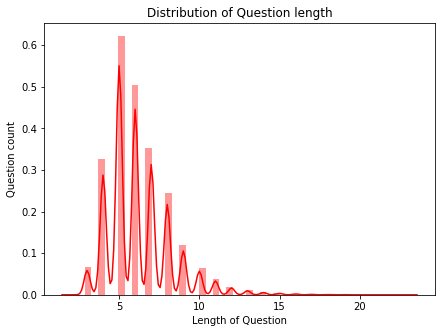

In [43]:
import seaborn as sns
plt.figure(figsize=(7,5))
sns.distplot(length_list, color='red')
plt.title('Distribution of Question length')
plt.xlabel('Length of Question')
plt.ylabel('Question count')
plt.show()

In [44]:
first_word_list = []
for question in tqdm.tqdm(vquestions):
  first_word_list.append(question.split()[0].lower())

100%|██████████████████████████████████████████████████████████████████████| 121512/121512 [00:00<00:00, 546649.49it/s]


In [45]:
print('There are ',len(set(first_word_list)),' types of questions in the dataset.')

There are  178  types of questions in the dataset.


In [46]:
ans_count = val_dataframe['Answer'].value_counts()
print(ans_count)


yes              27890
no               17744
2                 3835
white             2296
1                 2277
                 ...  
dunkin donuts        8
america              8
suitcases            8
skating              8
unsure               8
Name: Answer, Length: 1000, dtype: int64


In [47]:
num_words = 5000
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(val_dataframe['Question'].values)
Questions = tokenizer.texts_to_sequences(val_dataframe['Question'].values)

word_index = tokenizer.word_index
print('Number of unique tokens: %s tokens.' % len(word_index))

max_text_len = 200
Questions = pad_sequences(Questions, maxlen=max_text_len)

Number of unique tokens: 9735 tokens.


In [48]:

tokenizer.fit_on_texts(val_dataframe['Question'].values)
vQuestions = tokenizer.texts_to_sequences(val_dataframe['Question'].values)

word_index = tokenizer.word_index
print('Number of unique tokens: %s tokens.' % len(word_index))

max_text_len = 200
vQuestions = pad_sequences(vQuestions, maxlen=max_text_len)

Number of unique tokens: 9735 tokens.


In [49]:
embeddings_index = {}
f = open('./glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Number of word vectors: %s word vectors.' % len(embeddings_index))

Number of word vectors: 400000 word vectors.


In [50]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [51]:
from keras.layers import Embedding

embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=max_text_len,
                            trainable=True)

In [52]:
from keras.layers import dot
from keras.layers import Add
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras import backend as K
from keras.models import *
INPUT_DIM=2
TIME_STEPS = 20
one_atten_vec = False
lstm_post_atten = False

def attention_layer(inputs):
    a = Permute((2 ,1))(inputs)
    a = tf.keras.layers.Dense(TIME_STEPS, activation='softmax')(a)
    if one_atten_vec:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(32)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_layer = dot([inputs, a_probs],axes=2)
    return output_attention_layer

In [53]:
inputs = tf.keras.layers.Input(shape=(TIME_STEPS, INPUT_DIM,))
lstm_units = 256
lstm_out = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(inputs)
output = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_out)
model = tf.keras.Model(inputs=[inputs], outputs=output)

In [54]:
labels=len(np.unique(np.array(val_dataframe['Answer'].tolist())))

In [55]:
labelss=1000

In [56]:
from keras.layers import Activation, Concatenate, Permute, SpatialDropout1D, RepeatVector, LSTM, Bidirectional, Multiply, Lambda, Dense, Dropout, Input,Flatten,Embedding
from keras.models import Model
import keras.backend as K

class Attention:
    def __call__(self, inp, combine=True, return_attention=True):
        # Expects inp to be of size (?, number of words, embedding dimension)
        
        repeat_size = int(inp.shape[-1])
        
        # Map through 1 Layer MLP
        x_a = Dense(repeat_size, kernel_initializer = 'glorot_uniform', activation="tanh", name="tanh_mlp")(inp) 
        
        # Dot with word-level vector
        x_a = Dense(1, kernel_initializer = 'glorot_uniform', activation='linear', name="word-level_context")(x_a)
        x_a = Flatten()(x_a) # x_a is of shape (?,200,1), we flatten it to be (?,200)
        att_out = Activation('softmax')(x_a) 
        
        # Clever trick to do elementwise multiplication of alpha_t with the correct h_t:
        # RepeatVector will blow it out to be (?,120, 200)
        # Then, Permute will swap it to (?,200,120) where each row (?,k,120) is a copy of a_t[k]
        # Then, Multiply performs elementwise multiplication to apply the same a_t to each
        # dimension of the respective word vector
        x_a2 = RepeatVector(repeat_size)(att_out)
        x_a2 = Permute([2,1])(x_a2)
        out = Multiply()([inp,x_a2])
        
        if combine:
        # Now we sum over the resulting word representations
            out = Lambda(lambda x : K.sum(x, axis=1), name='expectation_over_words')(out)
        
        if return_attention:
            out = (out, att_out)
                   
        return out
    
    

In [57]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
embed_dim = 300
lstm_out = 256
length_of_text=200

inputs_atten_model = tf.keras.layers.Input((length_of_text))
emb = embedding_layer(inputs_atten_model)

x = SpatialDropout1D(0.35)(emb)
x = Bidirectional(LSTM(lstm_out, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x, attention = Attention()(x)
#x = Dense(6, activation="sigmoid")(x)
attention_layer_output = tf.keras.layers.Flatten()(x)
atten_model = tf.keras.Model(inputs_atten_model, attention_layer_output)


#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, return_sequences=True),merge_mode='sum')
#attention_layter_output = attention_layer(lstm(emb))
#lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out),merge_mode='sum')
#attention_layer_output = tf.keras.layers.Flatten()(lstm2(attention_layter_output))
#atten_model = tf.keras.Model(inputs_atten_model, attention_layer_output)
print(atten_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 300)     2920800     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 512)     1140736     ['spatial_dropout1d[0][0]']

In [59]:
# Importing the VGG-16 architecture, without the top part
#vgg = tf.keras.applications.ResNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet=tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Setting the Fine-Tuning parameter
finetuning = True

if finetuning:
  freeze_until = 13
  for layer in resnet.layers[:freeze_until]:
    layer.trainable = False
else:
  resnet.trainable = False

In [60]:
# Importing Keras libraries for easier use
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

# Defining the CNN part, which deals with the image
# It consists in the VGG-16 architecture imported before, followed of course by a Flatten layer
vision_model = Sequential()
vision_model.add(resnet)
vision_model.add(BatchNormalization())
vision_model.add(Flatten())

image_input = Input(shape=(224, 224, 3))
encoded_image = vision_model(image_input)

# Defining the RNN part, which deals with the question
# It consists in an Embedding, followed by three LSTM layers, each one with 256 units
#question_input_model = Input(shape=[200], dtype='int32')
#embedded_question = Embedding(input_dim=len(word_index)+1, output_dim=256, input_length=200)(question_input_model)
#encoded_question_1 = LSTM(256, return_sequences=True)(embedded_question)
#encoded_question_2 = LSTM(256, return_sequences=True)(encoded_question_1)
#encoded_question_3 = LSTM(256)(encoded_question_2)

# Comcatenating the CNN and the RNN parts to get the output
#merged = tf.keras.layers.concatenate([encoded_question_3, encoded_image])
#output_model = Dense(labels, activation='softmax')(merged)
#vqa_model_3 = Model(inputs=[image_input, question_input_model], outputs=output_model)

# Printing out a summary of the network
#vqa_model_3.summary()

In [61]:
encoded_image

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'sequential')>

In [62]:
from keras.layers import *

ensemble_model = tf.keras.layers.concatenate([encoded_image,atten_model.output])
# output layer
output_layer = tf.keras.layers.Dense(labels, activation='softmax')(ensemble_model)


finalModel = tf.keras.Model([image_input,atten_model.input], output_layer)


In [63]:
# Setting up the callback to save the model weights after each epoch only if there is an improvement in term of validation accuracy    
callbacks = []
exp_dir='./'
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_dir, 
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=True)
callbacks.append(ckpt_callback)

# Early Stopping is inserted in the callback, stopping the training procedure if the validation loss increases for too long
early_stop = True
if early_stop:
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  callbacks.append(es_callback)

In [64]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

finalModel.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])
finalModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 300)     2920800     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 512)     1140736     ['spatial_dropout1d[0][0]']

In [66]:
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
#train_dataframe['Answer Encoded']= label_encoder.fit_transform(train_dataframe['Answer'])
#train_dataframe['Answer Encoded'].unique()

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
val_dataframe['Answer Encoded']= label_encoder.fit_transform(val_dataframe['Answer'])
val_dataframe['Answer Encoded'].unique()

<ipython-input-66-3937141da58b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_dataframe['Answer Encoded']= label_encoder.fit_transform(val_dataframe['Answer'])


array([982, 565, 995, 907,   1, 963, 136, 887,  18,  34, 530, 521,  39,
       411, 608, 206, 503, 913, 617, 867, 447, 433, 805, 720, 191, 167,
        11, 130, 850,  50, 801, 561, 493, 937, 250, 809, 135, 363, 653,
       903, 776, 414, 856, 345,  43, 795, 996, 129, 239, 525, 751, 780,
        19, 585, 486, 877, 377, 302,  94, 991, 633, 246, 396, 719, 709,
        53, 615,  49, 654, 792, 303, 180, 328,  56, 853,  65, 202, 119,
       198, 408, 372, 916, 306, 102, 674, 951, 662,  87,  29, 487, 999,
       846, 336, 602, 534,  20,   8, 367, 121, 125, 164, 228, 978, 765,
       199, 500, 194, 559, 543, 114,  41, 600, 969, 880,  85, 111,  89,
       523, 169, 604, 507, 497, 145, 462, 725, 753, 782, 980, 205, 370,
       240,  35, 449, 917, 590, 793, 188, 871,  16, 177, 666, 185,   9,
       973, 458,  83, 816,  47, 757,  30, 113, 227, 789, 628, 273, 384,
       668, 526, 710,   0, 964, 967, 490, 791, 231, 781, 671, 325, 330,
       120, 836, 420, 386, 749, 910,  69, 997, 218,  71, 308, 87

In [68]:
len(vanswers)

121512

In [69]:
#answers=np_utils.to_categorical(train_dataframe['Answer Encoded'],1000)  
vanswers=np_utils.to_categorical(val_dataframe['Answer Encoded'],1000)  
#images_paths=train_dataframe['Path'].tolist()
vimages_paths=val_dataframe['Path'].tolist()
train_data_gen=TrainingSequence(vimages_paths[20000:len(vanswers)],vQuestions[20000:len(vanswers)],vanswers[20000:len(vanswers)],16)
valid_data_gen=TrainingSequence(vimages_paths[0:20000],vQuestions[0:20000],vanswers[0:20000],16)

In [128]:
x=argmax(to_categorical(vanswers), axis=1)

In [130]:
predictions_test = label_encoder.inverse_transform(val_dataframe['Answer Encoded'])

In [117]:
vanswers

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [93]:
vimages_paths

['val2014/COCO_val2014_000000350623.jpg',
 'val2014/COCO_val2014_000000350623.jpg',
 'val2014/COCO_val2014_000000008647.jpg',
 'val2014/COCO_val2014_000000008647.jpg',
 'val2014/COCO_val2014_000000008647.jpg',
 'val2014/COCO_val2014_000000434410.jpg',
 'val2014/COCO_val2014_000000434410.jpg',
 'val2014/COCO_val2014_000000056205.jpg',
 'val2014/COCO_val2014_000000056205.jpg',
 'val2014/COCO_val2014_000000056205.jpg',
 'val2014/COCO_val2014_000000065227.jpg',
 'val2014/COCO_val2014_000000065227.jpg',
 'val2014/COCO_val2014_000000103488.jpg',
 'val2014/COCO_val2014_000000103488.jpg',
 'val2014/COCO_val2014_000000103488.jpg',
 'val2014/COCO_val2014_000000124039.jpg',
 'val2014/COCO_val2014_000000200296.jpg',
 'val2014/COCO_val2014_000000200296.jpg',
 'val2014/COCO_val2014_000000036012.jpg',
 'val2014/COCO_val2014_000000036012.jpg',
 'val2014/COCO_val2014_000000303566.jpg',
 'val2014/COCO_val2014_000000303566.jpg',
 'val2014/COCO_val2014_000000303566.jpg',
 'val2014/COCO_val2014_00000008401

In [70]:
# Setting up the callback to save the model weights after each epoch only if there is an improvement in term of validation accuracy    
callbacks = []
exp_dir='./'
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_dir, 
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=True)
callbacks.append(ckpt_callback)

# Early Stopping is inserted in the callback, stopping the training procedure if the validation loss increases for too long
early_stop = True
if early_stop:
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  callbacks.append(es_callback)

In [71]:
finalModel.fit(train_data_gen,
                epochs=10,
                steps_per_epoch=(len(train_data_gen) // 16),
                validation_data=valid_data_gen,
                validation_steps=(len(valid_data_gen) // 16))

Epoch 1/10
332/332 [==============================] - 2649s 8s/step - loss: 4.6000 - accuracy: 0.2445 - val_loss: 24.8667 - val_accuracy: 0.0032
Epoch 2/10
332/332 [==============================] - 2463s 7s/step - loss: 4.2993 - accuracy: 0.2609 - val_loss: 18.9952 - val_accuracy: 0.0016
Epoch 3/10
332/332 [==============================] - 2489s 7s/step - loss: 4.4857 - accuracy: 0.2799 - val_loss: 13.2881 - val_accuracy: 0.1931
Epoch 4/10
332/332 [==============================] - 2486s 7s/step - loss: 4.1761 - accuracy: 0.2861 - val_loss: 9.6888 - val_accuracy: 0.2804
Epoch 5/10
332/332 [==============================] - 2451s 7s/step - loss: 3.3530 - accuracy: 0.3151 - val_loss: 2.7506 - val_accuracy: 0.3590
Epoch 6/10
332/332 [==============================] - 2416s 7s/step - loss: 2.5915 - accuracy: 0.3528 - val_loss: 19.7214 - val_accuracy: 0.3558
Epoch 7/10
332/332 [==============================] - 2426s 7s/step - loss: 2.5345 - accuracy: 0.3579 - val_loss: 4.2126 - val_accur

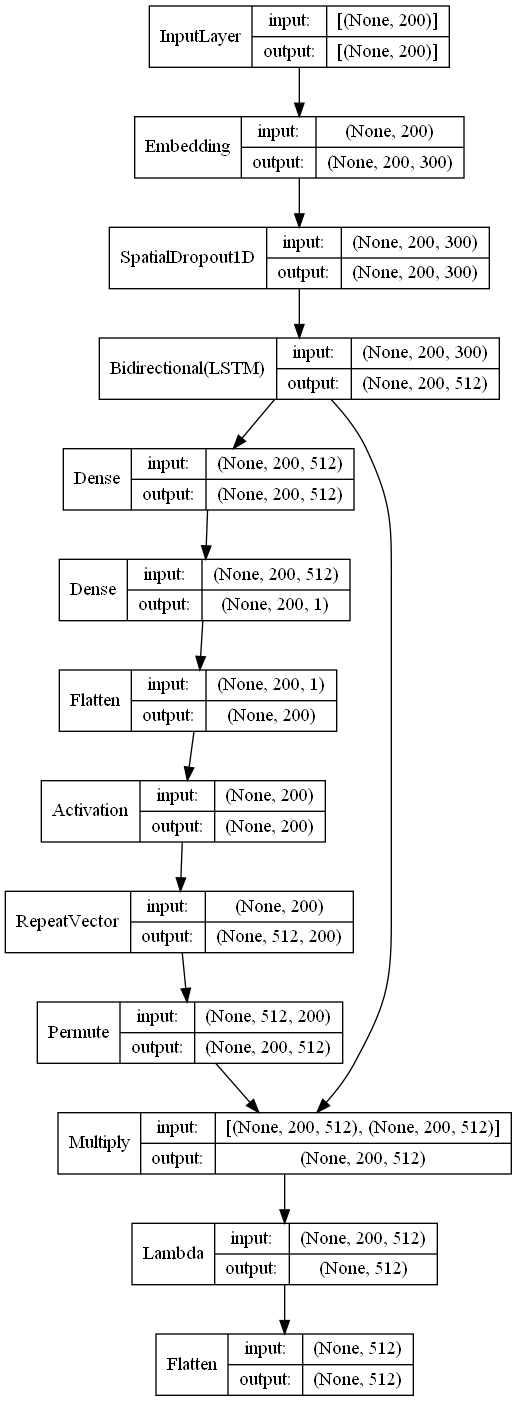

In [136]:
from keras.utils.vis_utils import plot_model
plot_model(atten_model, to_file='Q2_model_plot.png', show_shapes=True, show_layer_names=False)

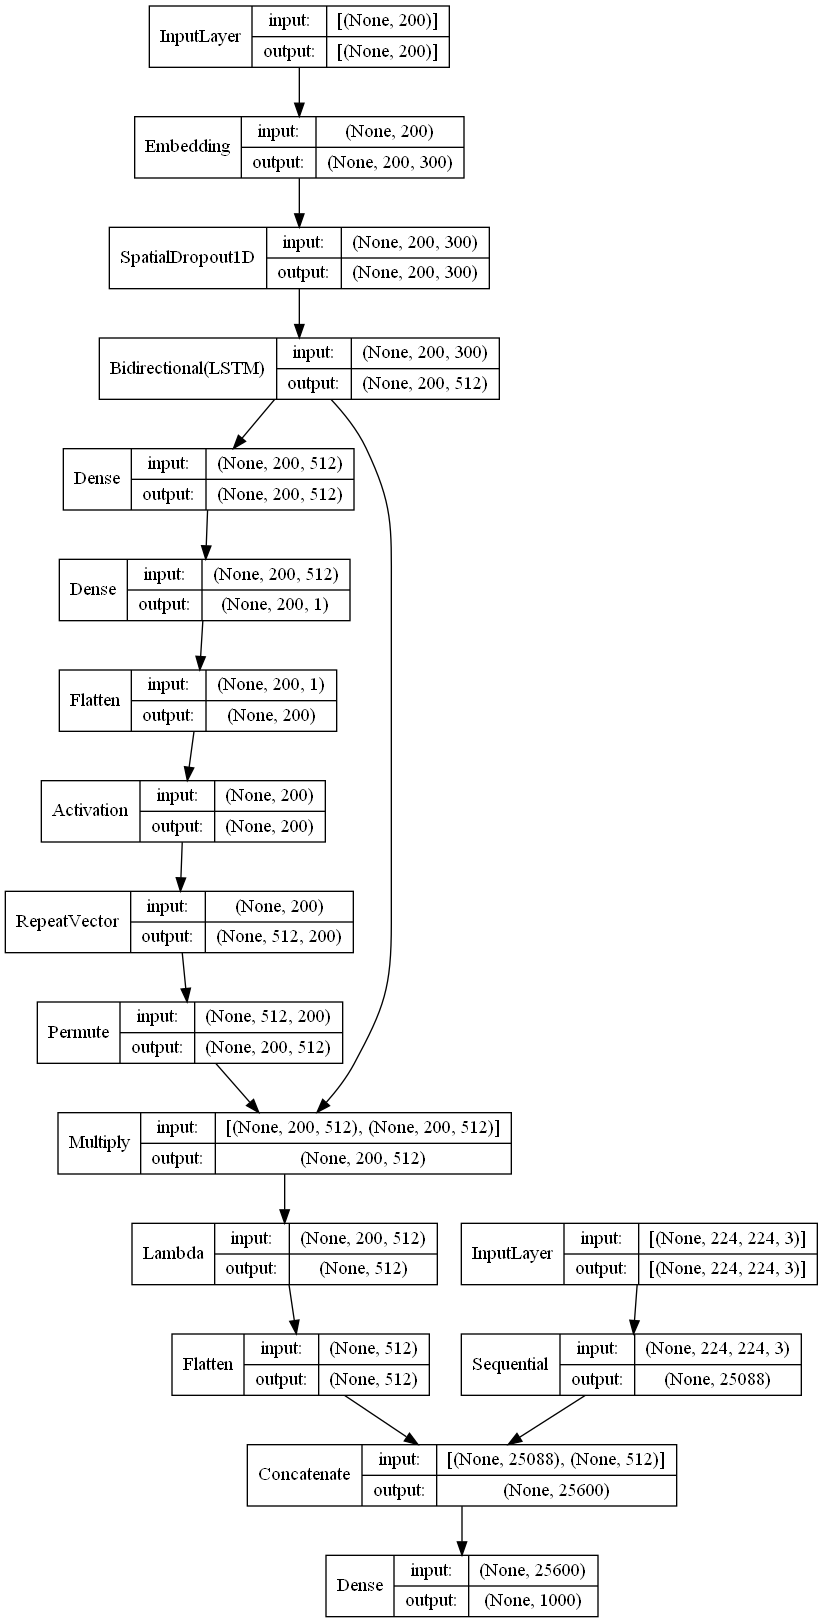

In [135]:
from keras.utils.vis_utils import plot_model
plot_model(finalModel, to_file='Model2_model_plot.png', show_shapes=True, show_layer_names=False)

In [108]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np

class sequence(Sequence):

    def __init__(self, x_set,RNN_train, batch_size):
        self.x1, self.x2 = x_set,RNN_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x1) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x2= self.x2[idx * self.batch_size:(idx + 1) * self.batch_size]
        print(self.x2)
        l1=[]
        for question in batch_x2:
         print(question)
         l1.append(question)
        
        l2=[]
        for img_name in batch_x1:
          print(img_name)
          im =resize(imread(img_name), (224, 224, 3))
          l2.append(im) 
         
          
        return [np.array(l2),np.array(l1)]

In [ ]:
def process_answer(ans):
    ans1=argmax(to_categorical(ans), axis=1)
    ans2 = label_encoder.inverse_transform(ans2)
    return ans2

In [88]:
def preprocess(txt):
    num_words = 5000
    t=txt.split() 
    tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
    tokenizer.fit_on_texts(t)
    txt_tokens = tokenizer.texts_to_sequences(t)

    word_index = tokenizer.word_index
    print('Number of unique tokens: %s tokens.' % len(word_index))

    max_text_len = 200
    txt_tokens_padded = pad_sequences(txt_tokens, maxlen=max_text_len)
    return txt_tokens

In [142]:
Question='ما هو لون الحافلة؟'
tr_question=translate(Question,False)
print(tr_question)
input_quest=preprocess(tr_question)

What color is the bus?
Number of unique tokens: 5 tokens.


In [115]:
imdir='%s/COCO_%s_%012d.jpg' 
image_path = imdir%('val2014', 'val2014',730)
im =resize(imread(image_path), (224, 224, 3))

In [106]:
image_path

'val2014/COCO_val2014_000000000730.jpg'

In [95]:
input_quest

[[1], [2], [3], [4], [5]]

In [110]:
inp=sequence(image_path,input_quest,1)

In [107]:
image_path

'val2014/COCO_val2014_000000000730.jpg'

In [104]:
inp

Populating the interactive namespace from numpy and matplotlib


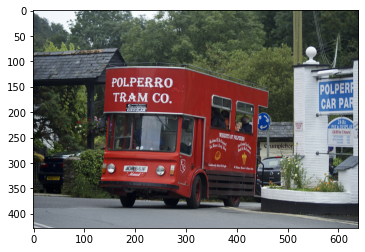

In [76]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

In [134]:
output=finalModel.predict([np.array(input_quest),np.array(im)])
ans = translate(process_ans(output), output=True)
print('Question: '+Question)
print('Answer: '+ans)

Question: ما هو لون الحافلة؟
Answer: احمر


In [150]:
imdir='%s/COCO_%s_%012d.jpg' 
image_path = imdir%('val2014', 'val2014',10580)
im =resize(imread(image_path), (224, 224, 3))

Populating the interactive namespace from numpy and matplotlib


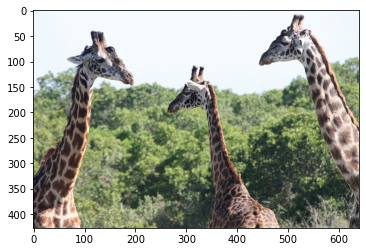

In [151]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

In [143]:
Question='كم عدد الزرافات؟'
tr_question=translate(Question,False)
print(tr_question)
input_quest=preprocess(tr_question)

How many giraffes?
Number of unique tokens: 3 tokens.


In [145]:
output=finalModel.predict([np.array(input_quest),np.array(im)])
ans = translate(process_ans(output), output=True)
print('Question: '+Question)
print('Answer: '+ans)

Question: كم عدد الزرافات؟
Answer: ۳


In [146]:
imdir='%s/COCO_%s_%012d.jpg' 
image_path = imdir%('val2014', 'val2014',16241)
im =resize(imread(image_path), (224, 224, 3))

Populating the interactive namespace from numpy and matplotlib


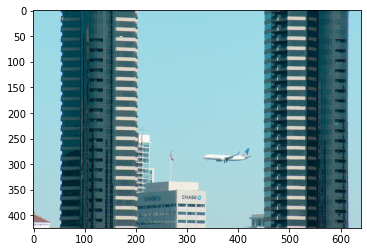

In [147]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

In [148]:
Question='كم عدد المبانى؟'
tr_question=translate(Question,False)
print(tr_question)
input_quest=preprocess(tr_question)

How many buildings?
Number of unique tokens: 3 tokens.


In [149]:
output=finalModel.predict([np.array(input_quest),np.array(im)])
ans = translate(process_ans(output), output=True)
print('Question: '+Question)
print('Answer: '+ans)

Question: كم عدد المبانى؟
Answer: ٢


In [49]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D,MaxPooling2D, Activation, Dropout, BatchNormalization, Input,LeakyReLU


model = tf.keras.Sequential() # define your model normally

model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape=(32,32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [229]:
from keras.layers import *

ensemble_model = tf.keras.layers.concatenate([encoded_image,atten_model.output])

In [ ]:
# output layer
output_layer = tf.keras.layers.Dense(labels, activation='softmax')(ensemble_model)


finalModel = tf.keras.Model([image_input,atten_model.input], output_layer)

In [ ]:
finalModel.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])
finalModel.summary()

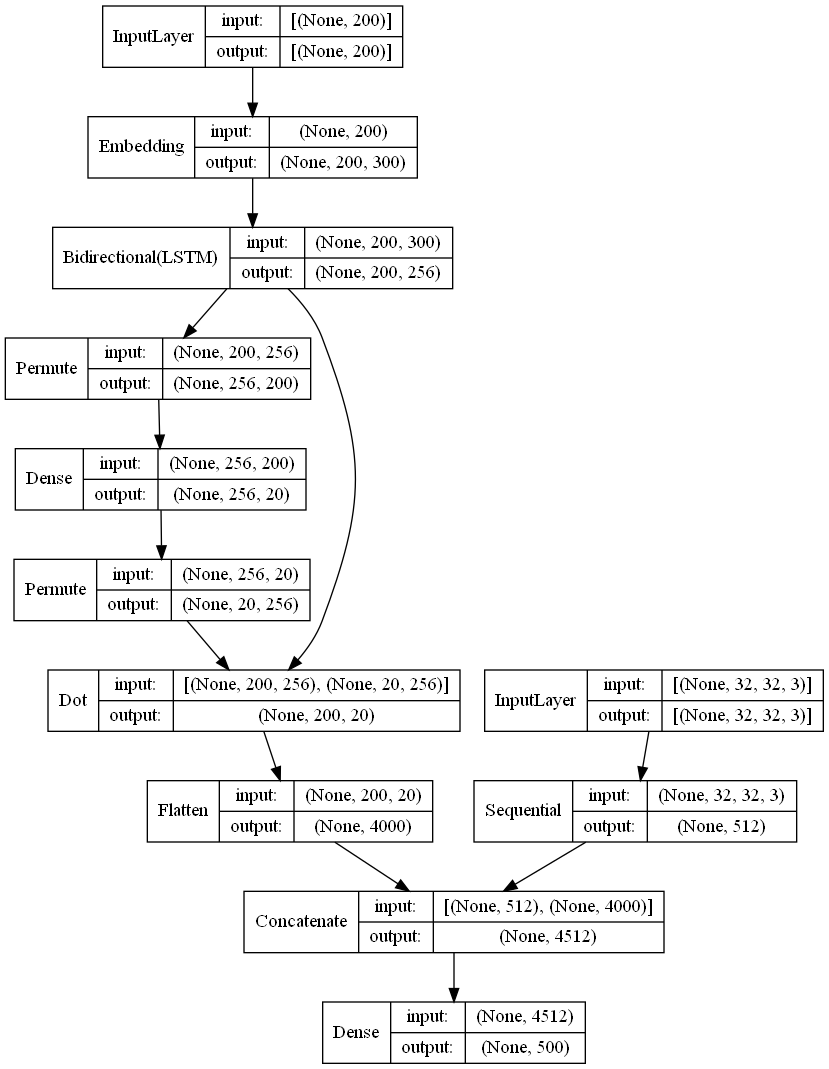

In [230]:
from keras.utils.vis_utils import plot_model
plot_model(finalModel, to_file='bidirectionalxcep_model_plot.png', show_shapes=True, show_layer_names=False)

In [232]:
# Importing Keras libraries for easier use
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential

# Defining the CNN part, which deals with the image
# It consists in the VGG-16 architecture imported before, followed of course by a Flatten layer
vision_model = Sequential()
vision_model.add(vgg)
vision_model.add(Flatten())

image_input = Input(shape=(400, 700, 3))
encoded_image = vision_model(image_input)

# Defining the RNN part, which deals with the question
# It consists in an Embedding, followed by three LSTM layers, each one with 256 units
question_input_model = Input(shape=[200], dtype='int32')
embedded_question = Embedding(input_dim=len(word_index)+1, output_dim=256, input_length=200)(question_input_model)
encoded_question_1 = LSTM(256, return_sequences=True)(embedded_question)
encoded_question_2 = LSTM(256, return_sequences=True)(encoded_question_1)
encoded_question_3 = LSTM(256)(encoded_question_2)

# Comcatenating the CNN and the RNN parts to get the output
merged = tf.keras.layers.concatenate([encoded_question_3, encoded_image])
output_model = Dense(labels, activation='softmax')(merged)
vqa_model_3 = Model(inputs=[image_input, question_input_model], outputs=output_model)

# Printing out a summary of the network
vqa_model_3.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 200, 256)     3881216     ['input_25[0][0]']               
                                                                                                  
 lstm_28 (LSTM)                 (None, 200, 256)     525312      ['embedding_8[0][0]']            
                                                                                                  
 lstm_29 (LSTM)                 (None, 200, 256)     525312      ['lstm_28[0][0]']                
                                                                                           

In [224]:
encoded_question = tf.keras.layers.LSTM(256)(embedded_question)
merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
output_model = Dense(labels, activation='softmax')(merged)
vqa_model_0 = Model(inputs=[image_input, question_input_model], outputs=output_model)

# Printing out a summary of the network
vqa_model_0.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 200, 256)     3881216     ['input_21[0][0]']               
                                                                                                  
 input_20 (InputLayer)          [(None, 400, 700, 3  0           []                               
                                )]                                                                
                                                                                                  
 lstm_25 (LSTM)                 (None, 256)          525312      ['embedding_7[0][0]']     

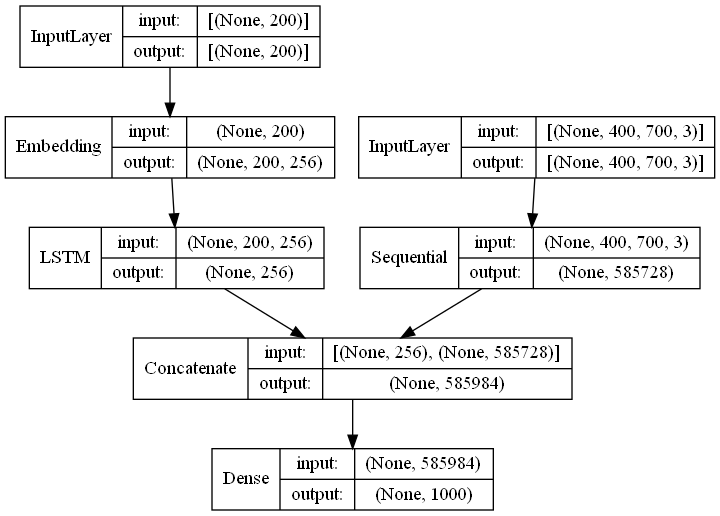

In [225]:
import tensorflow
from tensorflow import keras
keras.utils.plot_model(vqa_model_0, "VQA-BASEMODEL.png", show_shapes=True,show_layer_names=False)

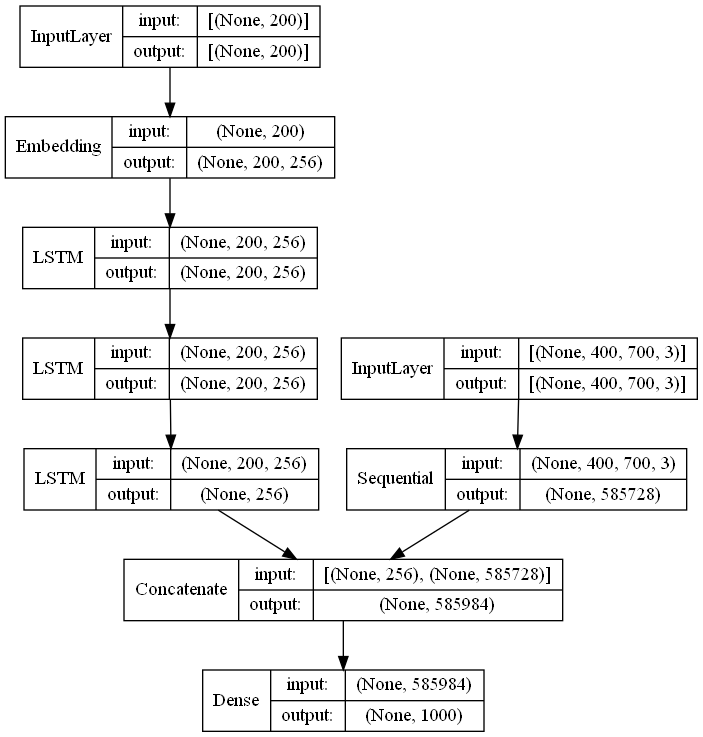

In [157]:
import tensorflow
from tensorflow import keras
keras.utils.plot_model(vqa_model_3, "VQA-XCEPTION3.png", show_shapes=True,show_layer_names=False)

In [217]:
# Setting up the callback to save the model weights after each epoch only if there is an improvement in term of validation accuracy    
callbacks = []
exp_dir='./'
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_dir, 
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=True)
callbacks.append(ckpt_callback)

# Early Stopping is inserted in the callback, stopping the training procedure if the validation loss increases for too long
early_stop = True
if early_stop:
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  callbacks.append(es_callback)